In [73]:
from openpiv import tools, pyprocess, validation, filters, scaling
import openpiv
import numpy as np
import matplotlib.pyplot as plt
import pyMRAW
import os
from skimage.io import imread
from mpl_toolkits.mplot3d import Axes3D

(1024, 1280)


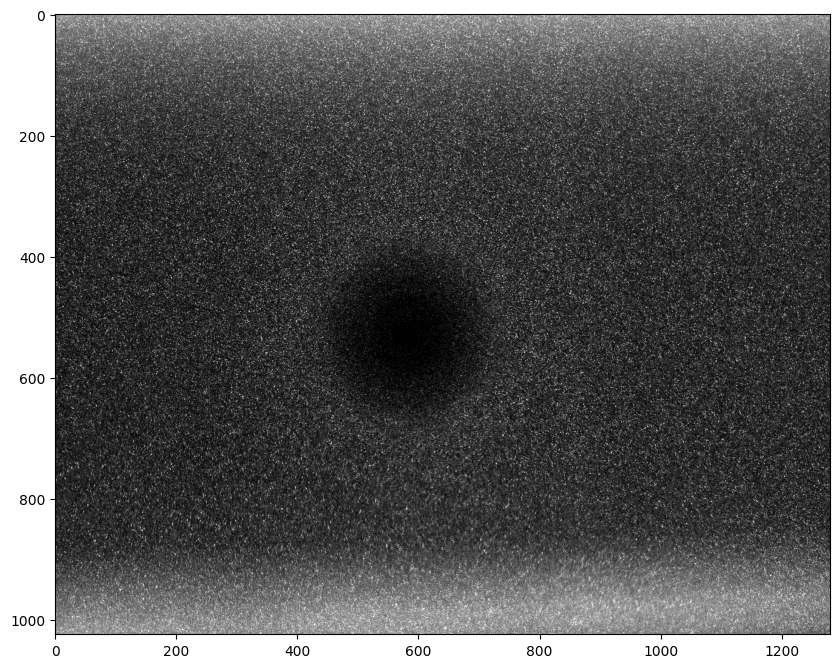

In [74]:
image1 = imread(r'C:\Users\sommacam\Desktop\PIV_training\images PIV\A001_1.tif')
print(image1.shape)
plt.figure(figsize = [10,10])
plt.imshow(image1, cmap="gray")

(1024, 1280)


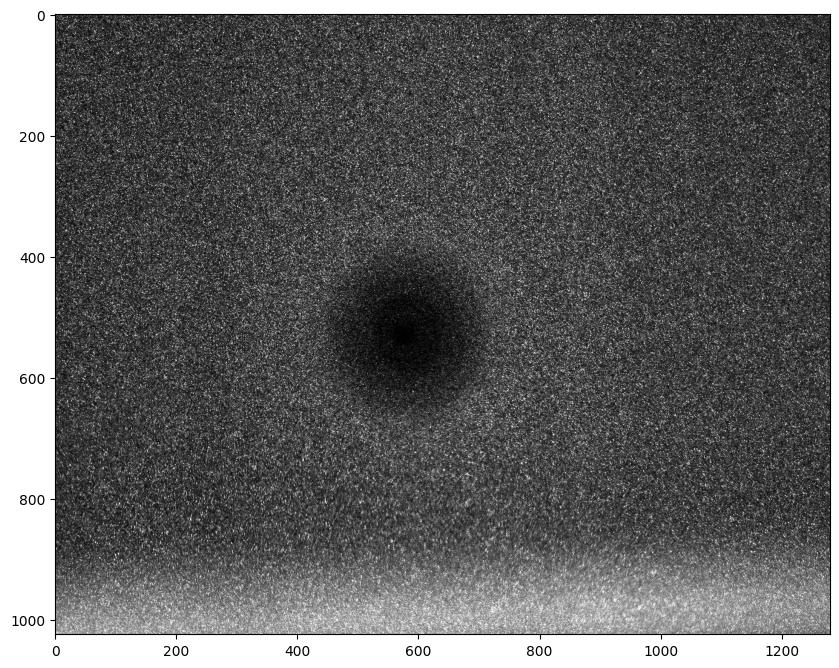

In [75]:
image2 = imread(r'C:\Users\sommacam\Desktop\PIV_training\images PIV\A001_2.tif')
print(image2.shape)
plt.figure(figsize = [10,10])
plt.imshow(image2, cmap="gray") 

Les 2 images montre les positions des particules à 2 différents intervalles de temps.
On va les analyser à partir de petites régions d'intéret (ROI), ce sont les fenêtres d'intérogation.
Ici on va utiliser des fenêtres de taille 32*32.
Jusqu'à récemment, les algorithmes rapides utilisaient des puissances de 2, alors les tailles sont toujours des puissance de 2 : 8, 16, 32, 64, 128 ...

# Création de la première fenêtre

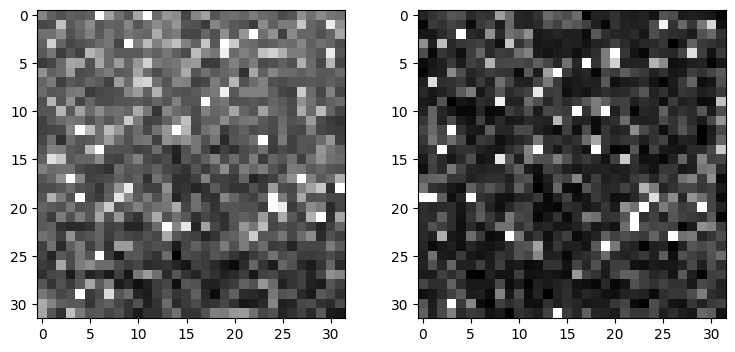

In [76]:
win_size = 32 # 32*32 pixels

win_1 = image1[:win_size, :win_size].copy()
win_2 = image2[:win_size, :win_size].copy()

# Affichage des fenêtres
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(win_1, cmap='gray')
axs[1].imshow(win_2, cmap='gray')
plt.show()

On devrait pouvoir voir le déplacment des particules entre l'image de droite qui est la fenêtre d'interogation et l'image de gauche qui est la même fenêtre prise quelque temps après.
32 étant trop pixelisé je passe à 64*64

Pour déterminer le déplacement on peut utiliser le principe des moindes carré ou la corrélation croisée.
Si on déplace la fenêtre A de quelques pixels et que l'on soustrait de l'image 2 le déplacement de l'image 1, on devrait voir à quel point le déplacement prédit bien le déplacement réele entre les 2.  

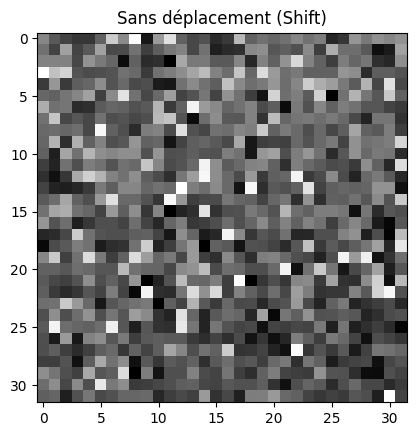

In [77]:
fig = plt.imshow(win_1 - win_2, cmap=plt.cm.gray)
plt.title("Sans déplacement (Shift)")
plt.show()

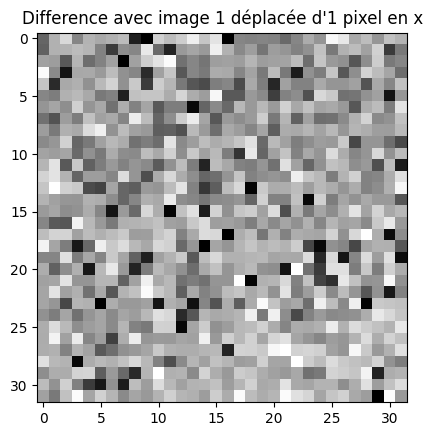

In [78]:
plt.imshow(win_2 - np.roll(win_1, (1, 0), axis=(0, 1)), cmap=plt.cm.gray) # np.roll() permet de shift les pixels d'une image
plt.title("Difference avec image 1 déplacée d'1 pixel en x")
plt.show()

La soustraction nous a permit de comprendre que dans la ROI les particules ne se sont pas déplacées entre les deux photos.

Je vais donc essayer de prendre un endroit où il y adéplacement.

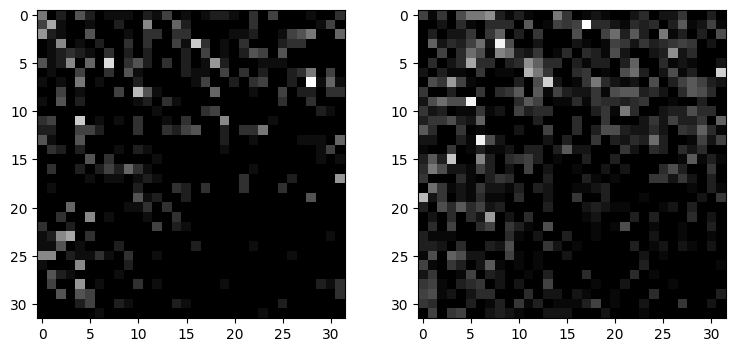

In [79]:
# Taille des images (1024, 1280) donc pour avoir le milieu en haut du trou 600,400
y, x = 500, 550
win_1 = image1[y:y+win_size, x:x+win_size].copy()
win_2 = image2[y:y+win_size, x:x+win_size].copy()
# Affichage des fenêtres
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(win_1, cmap='gray')
axs[1].imshow(win_2, cmap='gray')
plt.show()

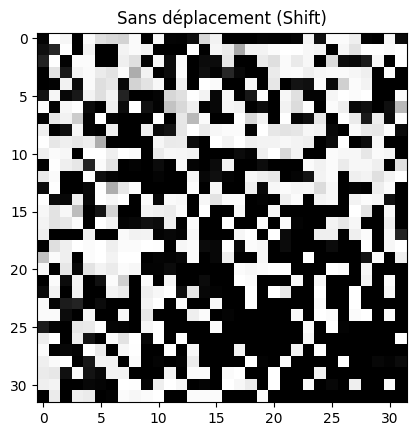

In [80]:
fig = plt.imshow(win_1 - win_2, cmap=plt.cm.gray)
plt.title("Sans déplacement (Shift)")
plt.show()

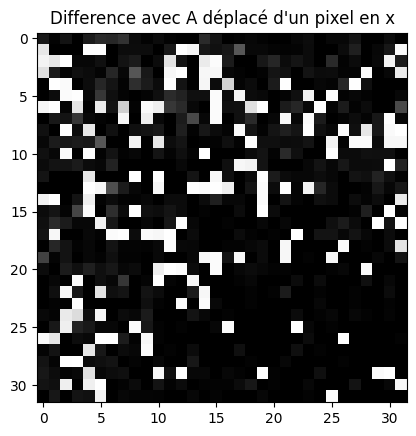

In [81]:
plt.imshow(win_2 - np.roll(win_1, (1, 0), axis=(0, 1)), cmap=plt.cm.gray) # np.roll() permet de shift les pixels d'une image
plt.title("Difference avec A déplacé d'un pixel en x")
plt.show()

On va maintenant essayer d'essayer de trouver le meilleur déplacement avec un algorithme.
On va utiliser la somme de la différence au carré du minimum

In [82]:
def match_template(img, template, maxroll=8):
    best_dist = np.inf 
    best_shift = (-1, -1)
    for y in range(maxroll):
        for x in range(maxroll):
            # calculate Euclidean distance
            dist = np.sqrt(np.sum((img - np.roll(template, (y, x), axis=(0, 1))) ** 2))
            if dist < best_dist:
                best_dist = dist
                best_shift = (y, x)
    return (best_dist, best_shift)

In [83]:
# indeed, when we find the correct shift, we got zero distance. it's not so in real images:
best_dist, best_shift = match_template(win_1, win_2)
print(f"{best_dist=}")
print(f"{best_shift=}")

best_dist=236.76359517459605
best_shift=(0, 5)


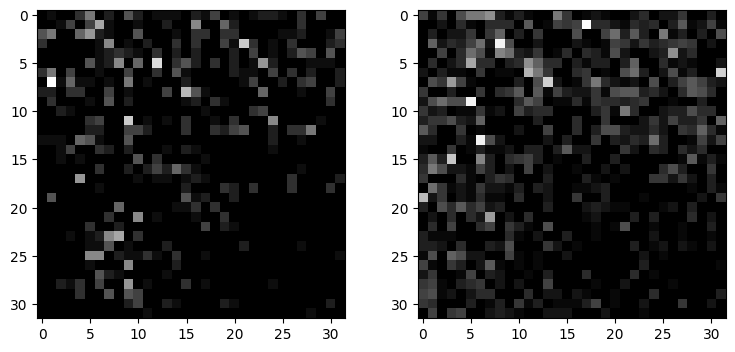

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(np.roll(win_1, best_shift, axis=(0, 1)), cmap='gray')
axs[1].imshow(win_2, cmap='gray')
plt.show()

Corrélation croisée

In [85]:
from scipy.signal import correlate

cross_corr = correlate(win_1 - win_2.mean(), win_2 - win_2.mean(), method="fft") # Ici on normalise en soustrayant avec la moyenne
# Note that it's approximately twice as large than the original windows, as we
# can shift a_win by a maximum of it's size - 1 horizontally and vertically
# while still maintaining some overlap between the two windows.
print("Taille du résultat de la cross corrrelation: %d x %d" % cross_corr.shape)

# 2ième façon de faire la corrélation croisée avec directement openpiv
cross_corr2 = openpiv.pyprocess.correlate_windows(win_1,win_2,correlation_method='fft')

Taille du résultat de la cross corrrelation: 63 x 63


Y = (63, 63) et X = (63, 63)
y = (63,) et x = (63,)
La shape des résultats de la corrélation croisée est de : (63, 63)


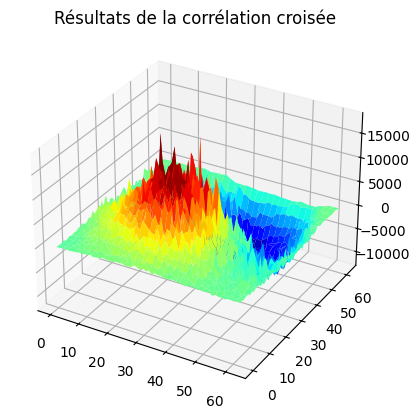

In [86]:
# Plot les résultats de la cross correlation => 2D de base donc avec le résultats => 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
Y, X = np.meshgrid(np.arange(cross_corr.shape[0]), np.arange(cross_corr.shape[1])) # Permet d'avoir le x et le y des résultats de la crosscorr en 2D
print(f'Y = {Y.shape} et X = {X.shape}')
y = np.arange(cross_corr.shape[0])
x = np.arange(cross_corr.shape[1])
print(f'y = {y.shape} et x = {x.shape}')
print(f"La shape des résultats de la corrélation croisée est de : {cross_corr.shape}")

ax.plot_surface(Y, X, cross_corr, cmap='jet', linewidth=0.2)  # type: ignore
plt.title("Résultats de la corrélation croisée")
plt.show()

cross_corr = (63, 63)
Le meilleur déplacement est en y=27, x=20 sur la carte de corrélation croisée


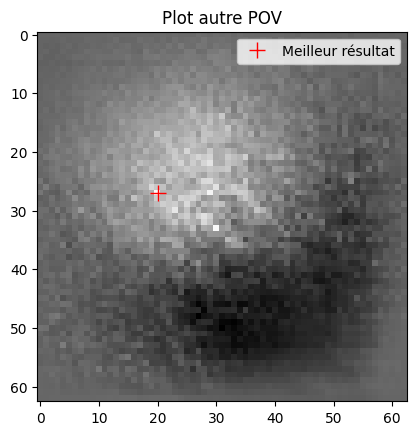

In [87]:
# Plot depuis le haut
plt.imshow(cross_corr, cmap='gray')
print(f'cross_corr = {cross_corr.shape}')
y, x = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
print(f"Le meilleur déplacement est en {y=}, {x=} sur la carte de corrélation croisée")

plt.plot(x, y, "+",color='red',markersize=12, linewidth=10, label='Meilleur résultat')
plt.legend()
plt.title("Plot autre POV")
plt.show()

In [91]:
# Essayer de trouver le déplacement ici sûrement pas bon à vérifier--------------------------------------------------------
from math import sqrt
# Définir la convertion en déplacement
#print(f'cross_corr = {cross_corr.shape}')
#cross_corr = cross_corr[np.newaxis,...] # Ajouter une nouvelle dim
print(f'cross_corr shape = {cross_corr.shape}')
x0 = 31
y0 = 31
deplacement = sqrt((x-x0)^2+(y-y0)^2) # centre des fenêtres initiales x0 et y0
print(f"Le déplacement des particules entre les 2 images pour la fenêtre d'interrogation est de {deplacement} unitées / unité de temps")

cross_corr shape = (63, 63)
Le déplacement des particules entre les 2 images pour la fenêtre d'interrogation est de 3.0 unitées / unité de temps


In [95]:
# On détermine le déplacement en x et en y
dy, dx = y - y0, x - x0
print(f"{dy=}, {dx=}")

# On peut donc avoir u et v en / par l'intervale de temps entre chaque image

dy=-4, dx=-11


In [97]:
# Création de la fonction pour bloucle et effectuer la cross correlation sur l'ensemble des fenêtres d'interrogation
def vel_field(curr_frame, next_frame, win_size): # arguments de la fonction paire d'image et la taille des fenêtres d'interrogation
    ys = np.arange(0, curr_frame.shape[0], win_size) 
    xs = np.arange(0, curr_frame.shape[1], win_size)
    # initialisation des vecteurs de déplacements
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs): # ici enumerate permet d'iterrer à partir de la liste
            int_win = curr_frame[y : y + win_size, x : x + win_size] # coordonnées interrogation window dans la première image donc x0 et y0
            search_win = next_frame[y : y + win_size, x : x + win_size] # Cordonnées de la fenêtre que l'on va shift dans la 2 ième image
            cross_corr = correlate(
                search_win - search_win.mean(), int_win - int_win.mean(), method="fft"
            ) # correlation en appliquant normalisation des pixels
            dys[iy, ix], dxs[iy, ix] = (
                np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
                - np.array([win_size, win_size])
                + 1
            )
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs, dys

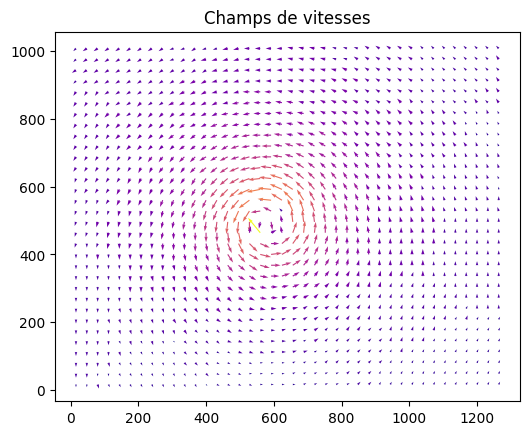

In [105]:
# Appel de la fonction sur les image 1 et 2 et taille des fenêtres 32*32
xs, ys, dxs, dys = vel_field(image1, image2, 32)

norm_drs = np.sqrt(dxs ** 2 + dys ** 2) # Distance

fig, ax = plt.subplots(figsize=(6, 6))
# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax.quiver( # Fonction de matplotlib qui permet de plot des flèches, ce qui va nous permetre de tracer les vecteurs de vitesses
    xs, # Départ x de la flêche
    ys[::-1], # inversement, départ y de la flêche
    dxs, 
    -dys, # - pour inversé dys
    norm_drs, # le déplacement pour adapter la taille des flêches en fonction
    cmap="plasma",
    angles="xy", # en coordonnées xy
    scale_units="xy", # ""
    scale=0.25, # facteur de mise à l'echelle de la taille des flêches https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.quiver.html
)
ax.set_aspect("equal") # Pour ajuster l'aspect de l'axe (même unitées x et y)
plt.title('Champs de vitesses')
plt.show()

Essai avec overlap, les résultats devrait être plus précis ------------------

In [113]:
def vel_field_asymmetric_wins(
    curr_frame, next_frame, half_int_win_size, half_search_win_size
):
    ys = np.arange(half_int_win_size[0], curr_frame.shape[0], 2 * half_int_win_size[0])
    xs = np.arange(half_int_win_size[1], curr_frame.shape[1], 2 * half_int_win_size[1])
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[
                y - half_int_win_size[0] : y + half_int_win_size[0],
                x - half_int_win_size[1] : x + half_int_win_size[1],
            ]
            search_win_y_min = y - half_search_win_size[0]
            search_win_y_max = y + half_search_win_size[0]
            search_win_x_min = x - half_search_win_size[1]
            search_win_x_max = x + half_search_win_size[1]
            truncated_search_win = next_frame[
                max(0, search_win_y_min) : min(image2.shape[0], search_win_y_max),
                max(0, search_win_x_min) : min(image2.shape[1], search_win_x_max),
            ]
            cross_corr = correlate(
                truncated_search_win - np.mean(truncated_search_win),
                int_win - np.mean(int_win),
                mode="valid",
                method="fft",
            )
            dy, dx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
            # if the top of the search window got truncated, shift the origin
            # up to the top edge of the (non-truncated) search window
            if search_win_y_min < 0:
                dy += -search_win_y_min
            # if the left of the search window got truncated, shift the origin
            # over to the left edge of the (non-truncated) search window
            if search_win_x_min < 0:
                dx += -search_win_x_min
            # shift origin to the center of the search window
            dy -= half_search_win_size[0] - half_int_win_size[0]
            dx -= half_search_win_size[1] - half_int_win_size[1]
            dys[iy, ix] = dy
            dxs[iy, ix] = dx
    return xs, ys, dxs, dys

In [114]:
int_win_size = np.array([32, 32])
print(f"{int_win_size=}")
assert np.all(np.array(image1.shape) % int_win_size == 0)
assert np.all(int_win_size % 2 == 0)
half_int_win_size = int_win_size // 2

search_win_size = int_win_size * 2
print(f"{search_win_size=}")
assert np.all(search_win_size % 2 == 0)
half_search_win_size = search_win_size // 2
assert np.all(search_win_size > int_win_size)
print(
    "max velocity that can be detected with these window sizes: "
    + f"{half_search_win_size - half_int_win_size}"
)

int_win_size=array([32, 32])
search_win_size=array([64, 64])
max velocity that can be detected with these window sizes: [16 16]


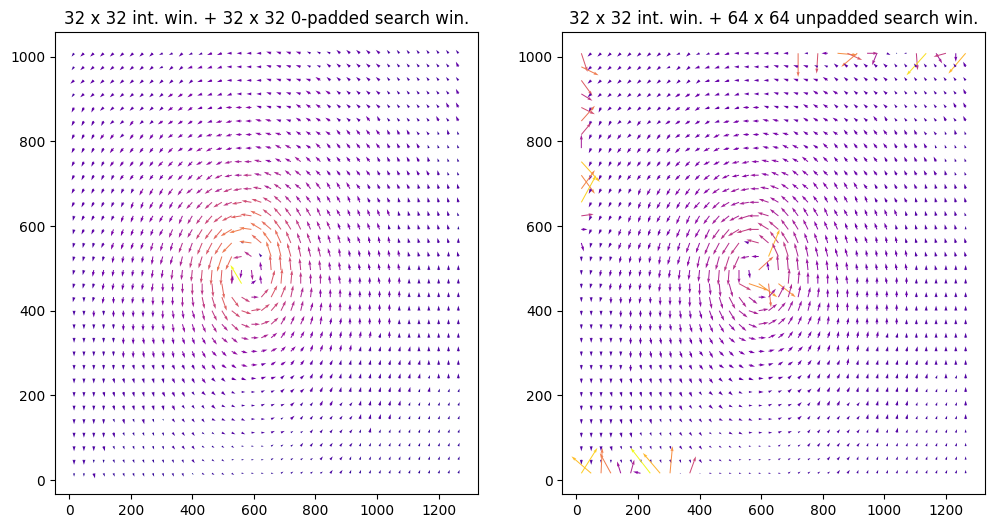

In [117]:
xs_asym, ys_asym, dxs_asym, dys_asym = vel_field_asymmetric_wins(
    image1, image2, half_int_win_size, half_search_win_size
)
norm_drs_asym = np.sqrt(dxs_asym ** 2 + dys_asym ** 2)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].quiver(
    xs,
    ys[::-1],
    dxs,
    -dys,
    norm_drs,
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
axs[1].quiver(
    xs_asym,
    ys_asym[::-1],
    dxs_asym,
    -dys_asym,
    norm_drs_asym,
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
axs[0].set_title(
    f"{win_size} x {win_size} int. win. + "
    f"{win_size} x {win_size} 0-padded search win."
)
axs[1].set_title(
    f"{int_win_size[0]} x {int_win_size[1]} int. win. + "
    f"{search_win_size[0]} x {search_win_size[0]} unpadded search win."
)
ax.set_aspect("equal")
plt.show()